In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # disable warnings and info
import tensorflow as tf
import tensorflow.keras as keras
import imageio
import moviepy.editor as mpy

SAMPLE_COL = 16
SAMPLE_ROW = 16
SAMPLE_NUM = SAMPLE_COL * SAMPLE_ROW

IMG_H = 64
IMG_W = 64
IMG_C = 3
IMG_SHAPE = (IMG_H, IMG_W, IMG_C)

BATCH_SIZE = 512
Z_DIM = 128
BZ = (BATCH_SIZE, Z_DIM)
BUF = 65536

IW_LR = 1e-4
IW_B1 = 0.
IW_B2 = 0.9
LAMBDA = 10
IW_EPOCH = 256

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 10000)])

In [3]:
# Utility function
def utPuzzle(imgs, row, col, path=None):
    h, w, c = imgs[0].shape
    out = np.zeros((h * row, w * col, c), np.uint8)
    for n, img in enumerate(imgs):
        j, i = divmod(n, col)
        out[j * h : (j + 1) * h, i * w : (i + 1) * w, :] = img
    if path is not None : imageio.imwrite(path, out)
    return out
  
def utMakeGif(imgs, fname, duration):
    n = float(len(imgs)) / duration
    clip = mpy.VideoClip(lambda t : imgs[int(n * t)], duration = duration)
    clip.write_gif(fname, fps = n)

In [4]:
path = './img_align_celeba_png/'

iTrain = next(os.walk(path))[2]
iTrain.sort()
iTrain

['000001.png',
 '000002.png',
 '000003.png',
 '000004.png',
 '000005.png',
 '000006.png',
 '000007.png',
 '000008.png',
 '000009.png',
 '000010.png',
 '000011.png',
 '000012.png',
 '000013.png',
 '000014.png',
 '000015.png',
 '000016.png',
 '000017.png',
 '000018.png',
 '000019.png',
 '000020.png',
 '000021.png',
 '000022.png',
 '000023.png',
 '000024.png',
 '000025.png',
 '000026.png',
 '000027.png',
 '000028.png',
 '000029.png',
 '000030.png',
 '000031.png',
 '000032.png',
 '000033.png',
 '000034.png',
 '000035.png',
 '000036.png',
 '000037.png',
 '000038.png',
 '000039.png',
 '000040.png',
 '000041.png',
 '000042.png',
 '000043.png',
 '000044.png',
 '000045.png',
 '000046.png',
 '000047.png',
 '000048.png',
 '000049.png',
 '000050.png',
 '000051.png',
 '000052.png',
 '000053.png',
 '000054.png',
 '000055.png',
 '000056.png',
 '000057.png',
 '000058.png',
 '000059.png',
 '000060.png',
 '000061.png',
 '000062.png',
 '000063.png',
 '000064.png',
 '000065.png',
 '000066.png',
 '000067.p

In [6]:
def preprocess_image(img_path):
    img = tf.io.read_file(path + img_path)
    img = tf.io.decode_png(img, channels=IMG_C)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, size=[IMG_H, IMG_W])
    
    return img

In [7]:
dsTrain = tf.data.Dataset.from_tensor_slices(iTrain)
dsTrain = dsTrain.shuffle(BUF).map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE, drop_remainder=True).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Metal device set to: Apple M1 Pro


In [8]:
def GAN(img_shape, z_dim):
    # x-shape
    xh, xw, xc = img_shape
    # z-shape
    zh = xh // 4
    zw = xw // 4
        
    # return Generator and Discriminator
    return keras.Sequential([ # Generator
        keras.layers.Dense(units  =  1024, input_shape = (z_dim,)),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dense(units  =  zh * zw << 8), # zh * zw * 256
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Reshape(target_shape = (zh, zw, 256)),
        keras.layers.Conv2DTranspose(
            filters = 32,
            kernel_size = 5,
            strides = 2,
            padding = "SAME"
        ),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Conv2DTranspose(
            filters = xc,
            kernel_size = 5,
            strides = 2,
            padding = "SAME",
            activation = keras.activations.sigmoid
        ),
    ]), keras.Sequential([ # Discriminator
        keras.layers.Conv2D(
            filters = 32,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME",
            input_shape = img_shape,
        ),
        keras.layers.LeakyReLU(),
        keras.layers.Conv2D(
            filters = 128,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME"
        ),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Flatten(),
        keras.layers.Dense(units  =  1024),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Dense(units  =  1),
    ])

s = tf.random.normal([SAMPLE_NUM, Z_DIM])

In [10]:
IWG, IWD = GAN(IMG_SHAPE, Z_DIM)
optimizer_g = keras.optimizers.Adam(    
    learning_rate=IW_LR,
    beta_1=IW_B1,
    beta_2=IW_B2,
)
optimizer_d = keras.optimizers.Adam(
    learning_rate=IW_LR,
    beta_1=IW_B1,
    beta_2=IW_B2,
)

@tf.function
def IWGTrain(c1):
    z = tf.random.normal(BZ)

    with tf.GradientTape() as tpg:
        c0 = IWG(z, training = True)

        z1 = IWD(c1, training = True)
        z0 = IWD(c0, training = True)

        ld = tf.reduce_mean(z0)
        lg = - ld
        ld = ld - tf.reduce_mean(z1)
        
        alpha = tf.random.uniform(shape=[], minval=0., maxval=1.)
        differences = c0 - c1
        interpolates = c1 + (alpha * differences)
        
        gradients = tf.gradients(IWD(interpolates, training = True), [interpolates])[0]
        slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients)))
        gradient_penalty = tf.reduce_mean((slopes-1.)**2)
        
        ld += LAMBDA * gradient_penalty

    gradient_g = tpg.gradient(lg, IWG.trainable_variables)

    optimizer_g.apply_gradients(zip(gradient_g, IWG.trainable_variables))
    
    return lg, ld

@tf.function
def IWDTrain(c1):
    z = tf.random.normal(BZ)

    with tf.GradientTape() as tpd:
        c0 = IWG(z, training = True)

        z1 = IWD(c1, training = True)
        z0 = IWD(c0, training = True)

        ld = tf.reduce_mean(z0)
        lg = - ld
        ld = ld - tf.reduce_mean(z1)
        
        alpha = tf.random.uniform(shape=[], minval=0., maxval=1.)
        differences = c0 - c1
        interpolates = c1 + (alpha * differences)
        
        gradients = tf.gradients(IWD(interpolates, training = True), [interpolates])[0]
        slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients)))
        gradient_penalty = tf.reduce_mean((slopes-1.)**2)
        
        ld += LAMBDA * gradient_penalty

    gradient_d = tpd.gradient(ld, IWD.trainable_variables)

    optimizer_d.apply_gradients(zip(gradient_d, IWD.trainable_variables))
    
    return lg, ld

Here in order to implement the improve WGAN there are several changes that should be made, such as:
- Using Adam optimizer with lr = 1e-4, beta_1 = 0. and beta_2 = 0.9
- Change the formula to calculate lg and ld

In [11]:
IWTrain = (
    IWDTrain,
    IWDTrain,
    IWDTrain,
    IWDTrain,
    IWGTrain
)

IWCritic = len(IWTrain)

Here inside IWTrain I only use 4 IWDTrain and 1 IWGTrain because in the pseudocode the iteration starts from 1 to 5 hence the length of IWCritic should be 5 instead of 6

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2f588d1e0>
    label = <none> 
    device = <AGXG13XDevice: 0x147663c00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x17d2ee600>
        label = <none> 
        device = <AGXG13XDevice: 0x147663c00>
            name = Apple M1 Pro 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x300ef6760>
    label = <none> 
    device = <AGXG13XDevice: 0x147663c00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x17d2ee600>
        label = <none> 
        device = <AGXG13XDevice: 0x147663c00>
            name = Apple M1 Pro 
    r

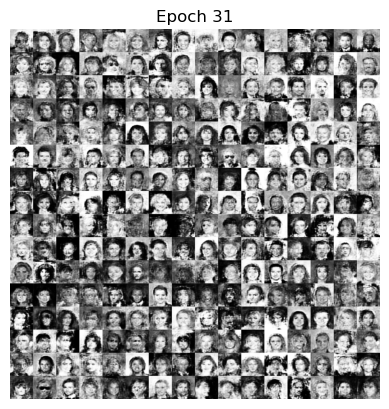

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x120297a50>
    label = <none> 
    device = <AGXG13XDevice: 0x147663c00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x17d2ee600>
        label = <none> 
        device = <AGXG13XDevice: 0x147663c00>
            name = Apple M1 Pro 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2849353e0>
    label = <none> 
    device = <AGXG13XDevice: 0x147663c00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x17d2ee600>
        label = <none> 
        device = <AGXG13XDevice: 0x147663c00>
            name = Apple M1 Pro 
    r

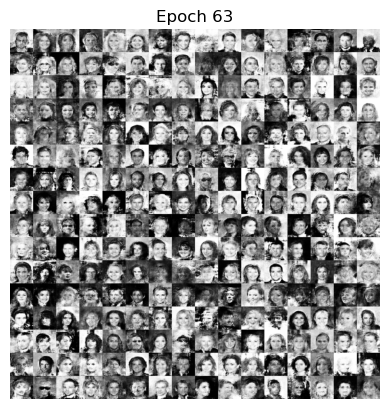

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x30474d390>
    label = <none> 
    device = <AGXG13XDevice: 0x147663c00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x17d2ee600>
        label = <none> 
        device = <AGXG13XDevice: 0x147663c00>
            name = Apple M1 Pro 
    retainedReferences = 1


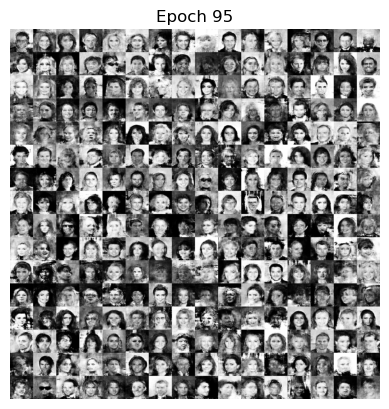

KeyboardInterrupt: 

In [13]:
iwlg = [None] * IW_EPOCH #record loss of g for each epoch
iwld = [None] * IW_EPOCH #record loss of d for each epoch
iwsp = [None] * IW_EPOCH #record sample images for each epoch

rsTrain = float(BATCH_SIZE) / float(len(iTrain))
ctr = 0

for ep in range(IW_EPOCH):
    lgt = 0.0
    ldt = 0.0
    
    for c1 in dsTrain:
        lg, ld = IWTrain[ctr](c1)
        ctr += 1
        lgt += lg.numpy()
        ldt += ld.numpy()
        if ctr == IWCritic : ctr = 0
    iwlg[ep] = lgt * rsTrain
    iwld[ep] = ldt * rsTrain
    
    out = IWG(s, training = False)
    img = utPuzzle(
        (out * 255.0).numpy().astype(np.uint8),
        SAMPLE_COL,
        SAMPLE_ROW,
        "imgs/iw_%04d.png" % ep
    )
    iwsp[ep] = img
    
    if (ep+1) % 32 == 0:
        plt.imshow(img[..., 0], cmap = "gray")
        plt.axis("off")
        plt.title("Epoch %d" % ep)
        plt.show()

Due to time constraints I've been training the model for 3 days but it seems that it can only reach epoch 96, hence I've decided to stop it and submit it as it is.

In [17]:
available_iwsp = list(filter(lambda item: item is not None, iwsp))
available_iwsp

[array([[[132, 131, 122],
         [123, 118, 119],
         [134, 120, 115],
         ...,
         [105, 126, 122],
         [135, 103, 135],
         [131, 131, 128]],
 
        [[124, 150, 124],
         [106, 164, 118],
         [113,  97, 123],
         ...,
         [167, 158, 171],
         [116, 146, 156],
         [180, 157, 177]],
 
        [[126, 139, 137],
         [115, 118, 100],
         [132, 134, 164],
         ...,
         [134, 130, 124],
         [132, 128, 134],
         [144, 126, 132]],
 
        ...,
 
        [[117, 141, 114],
         [131, 156, 181],
         [151,  83, 107],
         ...,
         [111, 156, 211],
         [146, 109, 155],
         [124, 131, 149]],
 
        [[142, 143, 134],
         [114, 138, 145],
         [113, 128, 166],
         ...,
         [150, 102, 137],
         [115, 121, 133],
         [135, 128, 154]],
 
        [[136, 120, 107],
         [140, 125, 136],
         [153,  95, 113],
         ...,
         [168, 119, 167],
  

In [18]:
utMakeGif(np.array(available_iwsp), "imgs/iwgan.gif", duration = 2)

t:  38%|███████████                  | 98/256 [02:58<00:33,  4.76it/s, now=None]

MoviePy - Building file imgs/iwgan.gif with imageio.



t: 100%|██████████████████████████████| 97/97 [00:21<00:00,  4.96it/s, now=None]


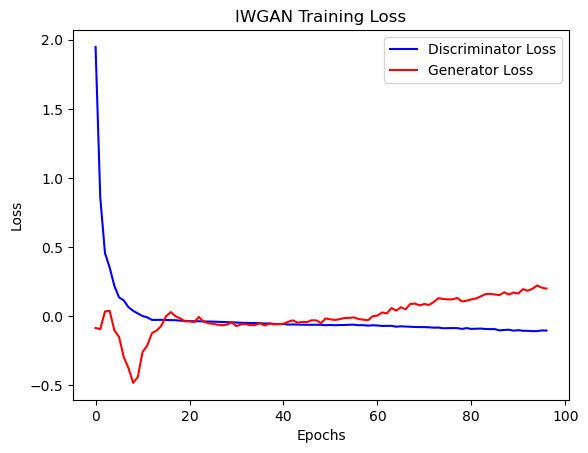

In [19]:
plt.plot(range(IW_EPOCH), iwld, color = "blue", label = "Discriminator Loss")
plt.plot(range(IW_EPOCH), iwlg, color = "red", label = "Generator Loss")
plt.legend(loc = "upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("IWGAN Training Loss")
plt.show()